# Predicting New York City Cab Fare

This files in this notebook were downloaded from the Kaggle Competition "New York City Taxi Fare Prediction" at https://www.kaggle.com/c/new-york-city-taxi-fare-prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data Wrangling

In [2]:
%%time
df = pd.read_csv('train.csv')

CPU times: user 1min 58s, sys: 1min 6s, total: 3min 4s
Wall time: 3min 37s


In [3]:
import feather

In [4]:
%%time
# Save into feather format, about 1.5Gb. 
df.to_feather('nyc_cab_fare_raw.feather')

CPU times: user 12.8 s, sys: 34.1 s, total: 46.9 s
Wall time: 59.1 s


In [5]:
%%time
# load the same dataframe next time directly, without reading the csv file again!
df = pd.read_feather('nyc_cab_fare_raw.feather')

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 18.8 s, sys: 33.9 s, total: 52.8 s
Wall time: 1min 57s


In [6]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [7]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,1.134505e+01,-7.250968e+01,3.991979e+01,-7.251121e+01,3.992068e+01,1.685380e+00
std,2.071083e+01,1.284888e+01,9.642353e+00,1.278220e+01,9.633346e+00,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.3+ GB


The max and min values seems like errors. More on that later. The dropoffs have a count less than the pickups. We can check for NaNs. 

### NaN Values

In [9]:
# Count number of reviews with no dropoff latitude
df.dropoff_latitude.isnull().sum()

376

In [10]:
# Check for null values
dfn = df[df.isnull().any(axis=1)]

In [11]:
# Display null values
dfn.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
120227,2012-12-11 12:57:00.00000013,12.50,2012-12-11 12:57:00 UTC,-73.992760,40.743098,NaN,NaN,0
245696,2013-03-21 18:07:07.0000001,86.50,2013-03-21 18:07:07 UTC,-73.991572,40.740591,NaN,NaN,0
340533,2012-12-11 12:50:52.00000010,27.50,2012-12-11 12:50:52 UTC,-73.979639,40.784742,NaN,NaN,0
428108,2011-09-08 09:12:52.0000001,11.80,2011-09-08 09:12:52 UTC,-73.987041,40.751542,NaN,NaN,0
471472,2012-12-11 12:34:20.0000006,7.80,2012-12-11 12:34:20 UTC,0.000000,0.000000,NaN,NaN,0
524834,2011-09-25 23:01:12.0000005,14.76,2011-09-25 23:01:12 UTC,-73.985374,40.768518,NaN,NaN,0
574023,2013-11-04 20:59:15.0000001,10.20,2013-11-04 20:59:15 UTC,-73.998460,40.745406,NaN,NaN,0
580338,2012-12-11 12:00:53.0000002,21.00,2012-12-11 12:00:53 UTC,-73.974743,40.752057,NaN,NaN,0
794694,2013-11-04 20:07:59.0000006,7.20,2013-11-04 20:07:59 UTC,-73.977048,40.787565,NaN,NaN,0
895400,2011-06-20 11:34:44.0000001,40.00,2011-06-20 11:34:44 UTC,-73.862900,40.768900,NaN,NaN,0


Since these rows all include fare amounts, they should be eliminated from the data. Had the cab just been running idle, the dropoff and pickup would have the same coordinates. Also note the pickup coordinates of 0. This must also be an error.

In [12]:
# Eliminate null values
df = df.dropna(axis=0, subset=['dropoff_latitude'])

In [13]:
# Verify that counts are the same
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07
mean,1.134500e+01,-7.250973e+01,3.991982e+01,-7.251121e+01,3.992068e+01,1.685391e+00
std,2.071087e+01,1.284878e+01,9.642324e+00,1.278220e+01,9.633346e+00,1.327662e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


### Latitude Longitude Corrections

According to https://www.mapdevelopers.com/geocode_bounding_box.php, New York City has the following bounds: 
North Latitude: 40.917577 
South Latitude: 40.477399 
East Longitude: -73.700272 
West Longitude: -74.259090

In [14]:
# Find cab rides whose pickup or dropoff are within NYC boundaries
# Declare constants
latmin = 40.477399
latmax = 40.917577
longmin = -74.259090
longmax = -73.700272

# Create dataframe with correct coordinates
df = df[((((df['pickup_longitude']<=longmax) & (df['pickup_longitude']>=longmin)) & ((df['pickup_latitude']<=latmax) & (df['pickup_latitude']>=latmin)))) | ((((df['dropoff_longitude']<=longmax) % (df['dropoff_longitude']>=longmin)) & ((df['dropoff_latitude']<=latmax) & (df['dropoff_latitude']>=latmin))))]

In [15]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.427071e+07,5.427071e+07,5.427071e+07,5.427071e+07,5.427071e+07,5.427071e+07
mean,1.131923e+01,-7.397545e+01,4.075083e+01,-7.391284e+01,4.071768e+01,1.685381e+00
std,2.080626e+01,3.458571e-02,2.694461e-02,3.471237e+00,3.171780e+00,1.315814e+00
min,-3.000000e+02,-7.425908e+01,4.047759e+01,-2.771290e+03,-3.481141e+03,0.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073657e+01,-7.399158e+01,4.073550e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075336e+01,-7.398059e+01,4.075382e+01,1.000000e+00
75%,1.250000e+01,-7.396832e+01,4.076752e+01,-7.396530e+01,4.076837e+01,2.000000e+00
max,9.396336e+04,-7.370028e+01,4.091755e+01,3.133219e+03,3.537133e+03,2.080000e+02


Some of the entries still don't make sense. Whereas the pickup might be correct, the min/max reveal dropoff

According to https://www.mapdevelopers.com/geocode_bounding_box.php, the boundary of the United States is as follows.
North Latitude: 71.538800 
South Latitude: 18.776300 
East Longitude: -66.885417 
West Longitude: 170.595700

Sticking to the Mainland, California gives the following:
West Longitude: -124.482003

In [16]:
# Choose cab rides whose pickup and dropoff are the US Mainland
# Declare constants
latmin = 5.496100
latmax = 71.538800
longmin = -124.482003
longmax = -66.885417

# Create dataframe with correct coordinates
df = df[((((df['pickup_longitude']<=longmax) & (df['pickup_longitude']>=longmin)) & ((df['pickup_latitude']<=latmax) & (df['pickup_latitude']>=latmin)))) & ((((df['dropoff_longitude']<=longmax) & (df['dropoff_longitude']>=longmin)) & ((df['dropoff_latitude']<=latmax) & (df['dropoff_latitude']>=latmin))))]

In [17]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.421767e+07,5.421767e+07,5.421767e+07,5.421767e+07,5.421767e+07,5.421767e+07
mean,1.131472e+01,-7.397546e+01,4.075084e+01,-7.397460e+01,4.075117e+01,1.685375e+00
std,2.080550e+01,3.455069e-02,2.693088e-02,4.513702e-02,5.484992e-02,1.315440e+00
min,-3.000000e+02,-7.425908e+01,4.047759e+01,-1.191480e+02,5.500000e+00,0.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073657e+01,-7.399159e+01,4.073558e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075336e+01,-7.398061e+01,4.075385e+01,1.000000e+00
75%,1.250000e+01,-7.396833e+01,4.076752e+01,-7.396539e+01,4.076838e+01,2.000000e+00
max,9.396336e+04,-7.370028e+01,4.091755e+01,-6.691319e+01,7.008333e+01,2.080000e+02


### Fare / Passenger Count Corrections

There still appear to be anomalies. There should not be 208 passengers in a taxi, or 0. It is conceivable that there could be 0 passengers, and money could be lost, but since the data includes pickups and dropoffs, and the goal is to predict cab fare, the entries with 0 passengers can be eliminated. Furthermore, this 208 passenger anomaly could be a cross state bus ride. It can also be eliminated. According to https://www1.nyc.gov/nyc-resources/faq/484/how-many-passengers-are-allowed-in-a-taxiIf, 4 or 5 people are allowed in a taxi, plus one child under 9. I'll assume a couple more can crowd in and the driver will allow it.

In [18]:
# Only choose cabs between 1 and 9 riders
df = df[(df['passenger_count'] < 10) & (df['passenger_count'] > 0)]

In [19]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.402688e+07,5.402688e+07,5.402688e+07,5.402688e+07,5.402688e+07,5.402688e+07
mean,1.132304e+01,-7.397546e+01,4.075084e+01,-7.397460e+01,4.075116e+01,1.691236e+00
std,2.083836e+01,3.456311e-02,2.693433e-02,4.518246e-02,5.488711e-02,1.307088e+00
min,-3.000000e+02,-7.425908e+01,4.047759e+01,-1.191480e+02,5.500000e+00,1.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073657e+01,-7.399159e+01,4.073557e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075336e+01,-7.398061e+01,4.075385e+01,1.000000e+00
75%,1.250000e+01,-7.396833e+01,4.076752e+01,-7.396538e+01,4.076838e+01,2.000000e+00
max,9.396336e+04,-7.370028e+01,4.091755e+01,-6.691319e+01,7.008333e+01,9.000000e+00


This looks better, but there are still problems with the min and the max. Also, that max fare keeps coming up with a different passenger_count.

In [20]:
df[df['fare_amount']>=10000]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
18859340,2013-08-20 11:52:52.0000001,61550.86,2013-08-20 11:52:52 UTC,-73.967711,40.755965,-73.945572,40.747666,1
41032263,2015-02-24 08:57:37.0000004,93963.36,2015-02-24 08:57:37 UTC,-73.994461,40.712353,-74.012543,40.702904,2
41186018,2015-05-03 09:35:20.0000001,75747.02,2015-05-03 09:35:20 UTC,-73.967949,40.792355,-73.990898,40.738976,1


It is possible that people are going to California and back, but even so, this messes with the data. We are presuming that the dropoff is the goal destination, but this won't always be the case.

In [21]:
# Choose only cab rides that are less than 10,000.
df = df[df['fare_amount']<10000]

No one should have a negative cab ride. According to Dr. Google, the NYC Taxi base fare recently increased from 2 to 2.50. It's unclear what the minimum cab fare should be for this dataset. A histogram should verify things.

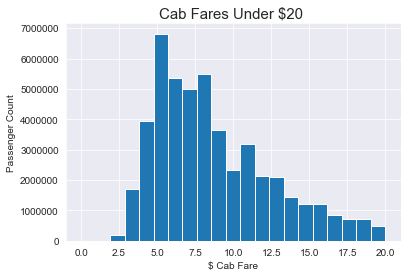

In [22]:
# Setup Seaborn
import seaborn as sns
sns.set_style("darkgrid")

# Create histogram of 20 bins showing fares from 0 to $20
plt.hist(df.fare_amount, bins=21, range=(0,20), ec='white')

# Create labels
plt.xlabel('$ Cab Fare')
plt.ylabel('Passenger Count')
plt.title('Cab Fares Under $20 ', fontsize=15)

# Save figure
plt.savefig("Cab_Fares_Under_20_Hist", dpi=300)

# Show graph
plt.show()

The histogram reveals that the mininum cab fare was 2.50 during the time period that the data was collected.

In [23]:
# Eliminate cab rides less than $2.50
df = df[df['fare_amount'] >= 2.50]

In [24]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.402291e+07,5.402291e+07,5.402291e+07,5.402291e+07,5.402291e+07,5.402291e+07
mean,1.131997e+01,-7.397546e+01,4.075084e+01,-7.397460e+01,4.075116e+01,1.691238e+00
std,9.724556e+00,3.455982e-02,2.693309e-02,4.517953e-02,5.488774e-02,1.307091e+00
min,2.500000e+00,-7.425908e+01,4.047759e+01,-1.191480e+02,5.500000e+00,1.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073657e+01,-7.399159e+01,4.073557e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075336e+01,-7.398061e+01,4.075385e+01,1.000000e+00
75%,1.250000e+01,-7.396833e+01,4.076752e+01,-7.396538e+01,4.076838e+01,2.000000e+00
max,9.000410e+03,-7.370028e+01,4.091755e+01,-6.691319e+01,7.008333e+01,9.000000e+00


Still a couple of issues. The min fare looks good, but the max seems quite high. Also, the dropoff latitude and longitude of the min are way out of range.

One idea is to create a new column, distance, and then plot it against fare to determine outliers. While it's true that someone can rent a cab for hours zigzagging across NYC, and return to where they started, this kind of fare is going to distort the data.

In the meantime, here is a histogram of all the cab fares.

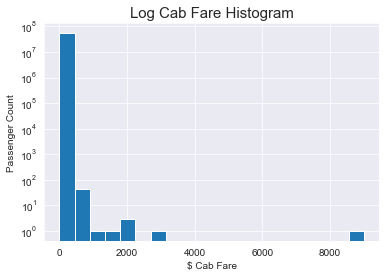

In [25]:
# Create log histogram of all current fares
plt.hist(df.fare_amount, bins=20, ec='white', log=True)
plt.xlabel('$ Cab Fare')
plt.ylabel('Passenger Count')
plt.title('Log Cab Fare Histogram', fontsize=15)
plt.savefig("Cab_Fare_Hist", dpi=300)
plt.show()

In [26]:
# Save file before adding new columns
df.to_csv('NYC_Cab_Fare_Wrangled.csv')

### Euclidean and Taxicab Distance

I am going to define both a Euclidean Distance, an unrealistic min since the shortest distance between 2 points is not a straight line through buildings and blocks, and a Taxicab Distance, a more realistic expectation of miles traveled. The Euclidean distance will serve as a min to eliminate outliers and errors. According to http://nymag.com/nymetro/urban/features/taxi/n_20286/, one could not do bretter than $1.50 per mile. 

In [27]:
# Define coordinates (x,y)
x1 = df['pickup_latitude']
y1 = df['pickup_longitude']
x2 = df['dropoff_latitude']
y2 = df['dropoff_longitude']

# Create Euclidean Distrance column
df['euclidean_distance'] = np.sqrt((y2-y1)**2 + (x2-x1)**2)

# Create Taxicab Distance column
df['taxicab_distance'] = np.abs(y2-y1) + np.abs(x2-x1)

# Convert to miles
df['euclidean_distance'] = df['euclidean_distance'] * 69
df['taxicab_distance'] = df['taxicab_distance'] * 69

# Show first five entries
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,taxicab_distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.651073,0.810198
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,5.499001,7.416189
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.943509,1.325628
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,1.748493,2.027634
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.343397,1.876386


#### Distance / Fare Plots

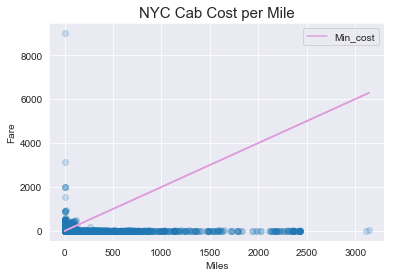

In [28]:
# Define x and y
x = df.euclidean_distance
y = df.fare_amount

# Create scatter plot
plt.scatter(x, y, alpha=0.2)

# Create labels
plt.ylabel('Fare')
plt.xlabel('Miles')

# Create title
plt.title('NYC Cab Cost per Mile', fontsize=15)

minLine, = plt.plot(x, 2.5 + 2*x, 'plum', label='Min_cost')

plt.legend(handles=[minLine])
plt.savefig('Cab Cost per Mile', dpi=300)
plt.show()

All rides underneath the plum line can be eliminated. Since the going rate was 2.50 per cab at 2.00 per mile in NYC, they are impossible.

In [ ]:
# Define x and y
x = df.euclidean_distance
y = df.fare_amount

# Prevent cell overflow
plt.rcParams['agg.path.chunksize'] = 10000

# Create scatter plot
plt.scatter(x, y, alpha=0.2)

# Create labels
plt.ylabel('Fare')
plt.xlabel('Miles')

# Create zoom limits
plt.xlim(0, 1000)
plt.ylim(0, 1000)

# Create title
plt.title('NYC Cab Cost per Mile', fontsize=15)

#Since helpful votes cannot exceed total votes, the cyan line represents a maximum. 
#All dots must be underneath the line
minLine, = plt.plot(x, 2.5 + 2*x, 'plum', label='Min_cost')

plt.legend(handles=[minLine])
plt.savefig('Cab Cost per Mile Zoom', dpi=300)
plt.show()

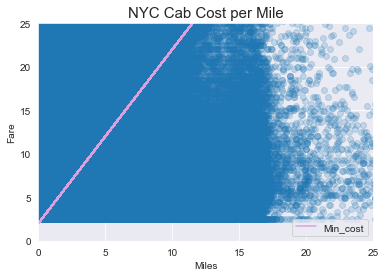

In [29]:
# Define x and y
x = df.euclidean_distance
y = df.fare_amount

# Prevent cell overflow
plt.rcParams['agg.path.chunksize'] = 10000

# Create scatter plot
plt.scatter(x, y, alpha=0.2)

# Create labels
plt.ylabel('Fare')
plt.xlabel('Miles')

# Create zoom limits
plt.xlim(0, 25)
plt.ylim(0, 25)

# Create title
plt.title('NYC Cab Cost per Mile', fontsize=15)

#Since helpful votes cannot exceed total votes, the cyan line represents a maximum. 
#All dots must be underneath the line
minLine, = plt.plot(x, 2.5 + 2*x, 'plum', label='Min_cost')

plt.legend(handles=[minLine])
plt.savefig('Cab Cost per Mile Zoom', dpi=300)
plt.show()

In [30]:
#### Eliminate unrealistic plots
df = df[df['fare_amount'] >= (df['euclidean_distance'] * 2 + 2.50)]

In [31]:
# Elminate fares that traveled no distance
df = df[df['euclidean_distance']>0]

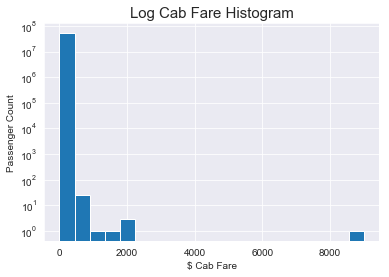

In [32]:
# Show updated log cab fare histogram
plt.hist(df.fare_amount, bins=20, ec='white', log=True)
plt.xlabel('$ Cab Fare')
plt.ylabel('Passenger Count')
plt.title('Log Cab Fare Histogram', fontsize=15)
plt.savefig("Cab_Fare_Hist_Updated", dpi=300)
plt.show()

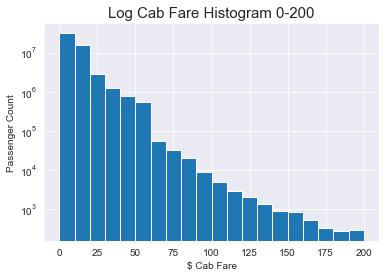

In [34]:
# Show zoomed in log cab fare histogram
plt.hist(df.fare_amount, bins=20, range=(0,200), ec='white', log=True)
plt.xlabel('$ Cab Fare')
plt.ylabel('Passenger Count')
plt.title('Log Cab Fare Histogram 0-200', fontsize=15)
plt.savefig("Cab_Fare_Hist_zoom", dpi=300)
plt.show()

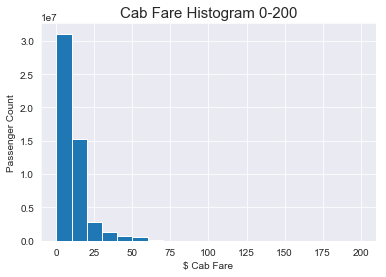

In [35]:
# Show zoomed in cab fare histogram
plt.hist(df.fare_amount, bins=20, range=(0,200), ec='white')
plt.xlabel('$ Cab Fare')
plt.ylabel('Passenger Count')
plt.title('Cab Fare Histogram 0-200', fontsize=15)
plt.savefig("Cab_Fare_Hist_0-200", dpi=300)
plt.show()

### Save File

In [36]:
# Save wrangled frame as csv file
df.to_csv('NYC_Cab_Fare_Wrangled.csv')

In [37]:
# Get rid of accumulated garbage
import gc
gc.collect()

14135

## Time Series

In [55]:
%%time
# If the kernel keeps dying, run statement underneath
df = pd.read_csv('NYC_Cab_Fare_Wrangled.csv', parse_dates=['pickup_datetime'])

CPU times: user 1h 52min 41s, sys: 2min 35s, total: 1h 55min 17s
Wall time: 2h 6min 53s


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51915840 entries, 0 to 51915839
Data columns (total 11 columns):
Unnamed: 0            int64
key                   object
fare_amount           float64
pickup_datetime       datetime64[ns]
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
passenger_count       int64
euclidean_distance    float64
taxicab_distance      float64
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 4.3+ GB


In [57]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,taxicab_distance
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.651073,0.810198
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,5.499001,7.416189
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.943509,1.325628
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,1.748493,2.027634
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.343397,1.876386


In [ ]:
#type(df.pickup_datetime[0])

In [ ]:
#def cut_UTC(row):
    #row = row.split(' UTC')
    #return row[0]

In [ ]:
#df['pickup_datetime'] = df['pickup_datetime'].apply(cut_UTC)

In [42]:
#df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'], errors='ignore')

In [58]:
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year
df['hour'] = df['pickup_datetime'].dt.hour
df['minute'] = df['pickup_datetime'].dt.minute
df['second'] = df['pickup_datetime'].dt.second
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek

In [59]:
df['15_min_intervals'] = 4 * df['hour'] + (df['minute']/15).astype(int)
df['total_seconds'] = 3600 * df['hour'] + 60 * df['minute'] + df['second']

In [60]:
def summer_month(row):
    if row['month'] in [6,7,8]:
        return 1
    else:
        return 0

df['summer_month'] = df.apply(summer_month, axis=1)

In [61]:
def cold_month(row):
    if row['month'] in [1,2,3,11,12]:
        return 1
    else:
        return 0
    
df['cold_month'] = df.apply(cold_month, axis=1)

KeyboardInterrupt: 

In [ ]:
def weekend(row):
    if row['dayofweek'] in [5,6]:
        return 1
    else:
        return 0

df['weekend'] = df.apply(weekend, axis=1)

In [ ]:
def rush_hour(row):
    if (row['hour'] in [7,8,9,15,16,17,18,19]) & (row['weekend'] == 0):
        return 1
    else:
        return 0

df['rush_hour'] = df.apply(rush_hour, axis=1)

In [ ]:
def night_rush(row):
    if (row['hour'] in [19,20,21,22,23,24,1]) & (row['dayofweek'] in [3,4,5]):
        return 1
    else:
        return 0
    
df['night_rush'] = df.apply(night_rush, axis=1)

In [ ]:
def night_charge(row):
    if row['hour'] in [20,21,22,23,24,1,2,3,4,5,6]:
        return 1
    else:
        return 0
    
df['night_charge'] = df.apply(night_charge, axis=1)

In [ ]:
def weekday_surcharge(row):
    if (row['hour'] in [16,17,18,19,20]) & (row['dayofweek'] in [1,2,3,4,5]):
        return 1
    else:
        return 0
    
df['weekday_surcharge'] = df.apply(weekday_surcharge, axis=1)

In [ ]:
df.head()

In [ ]:
df.describe()

In [54]:
df.to_csv('/Users/coreyjwade/Desktop/Data/NY_Cab_Fare/NYC_Cab_Fare_Wrangled_Time_Distance.csv')

NotADirectoryError: [Errno 20] Not a directory: '/Users/coreyjwade/Desktop/Data/NY_Cab_Fare/NYC_Cab_Fare_Wrangled_Time_Distance.csv/111.part'

## Holiday Additions

In [ ]:
#from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

#dr = pd.date_range(start='2015-07-01', end='2015-07-31')
#df = pd.DataFrame()
#df['Date'] = dr

#cal = calendar()
#holidays = cal.holidays(start=dr.min(), end=dr.max())

#df['Holiday'] = df['Date'].isin(holidays)
#print df

## Latitude Longitude Additions

In [ ]:
df = pd.read_csv('NYC_Cab_Fare_Wrangled_Time_Distance.csv')
df.head()

I used https://getlatlong.net/ to estimate a geographical area for Manhattan.

These are the 4 points, that when connected as a quadrilateral, enclose most of Manhattan. (I chose some points in the water since they are unaffected traffic

Then for any given point (x,y) both of the following conditions must hold:
bottom line <= (x,y) <= top line
right line <= (x,y) <= left line

Or, equilavlently,
bottom line <= mx + b <= top line
right line <= mx + b <= left line

For instance, to determine if (3,4) <= 2x+1,
the condition must be checked that
4 <= 2(3) + 1
which in this case is true.

In [ ]:
# Define line from two points and a provided column
def two_points_line(a, b, column):
        
    # Case when y-values are the same
    if b[1]==a[1]:
        
        # Slope defaults to 0
        slope = 0
        
    # Case when x-values are the same
    elif b[0]==a[0]:
        
        # Case when max value is less than 999999999
        if column.max() < 999999999:
            
            # Add 999999999 to max value
            slope = column.max() + 999999999
        
        # All other cases
        else:
            
            # Multiply max value by itself (greater than 999999999)
            slope = column.max() * column.max()
    
    # When x-values and y-values are not 0
    else:
        
        # Use standard slope formula
        slope = (b[1] - a[1])/(b[0]-a[0])
    
    
    # Equation for y-intercept (solving y=mx+b for b)
    y_int = a[1] - slope * a[0]
    
    # Return slope and y-intercept
    return slope, y_int

In [ ]:
upper_right = (-73.929224, 40.804328)
bottom_right = (-73.980036, 40.710706)
bottom_left = (-74.054880, 40.681292)
upper_left = (-73.966303, 40.830050)

In [ ]:
m_top, b_top = two_points_line(upper_right, upper_left, df.pickup_latitude)
m_left, b_left = two_points_line(bottom_left, upper_left, df.pickup_latitude)
m_right, b_right = two_points_line(bottom_right, upper_right, df.pickup_latitude)
m_bottom, b_bottom = two_points_line(bottom_right, bottom_left, df.pickup_latitude)

In [ ]:
def manhattan_test((a,b)(x,y)):
    if (((b >= (a * m_top + b_top)) &
    (b <= (a * m_bottom + b_bottom))) &
    ((b <= (a * m_right + b_right)) &
    (b >= (a * m_left + b_left)))) & (((y >= (x * m_top + b_top)) &
    (y <= (x * m_bottom + b_bottom))) &
    ((y <= (x * m_right + b_right)) &
    (y >= (x * m_left + b_left)))):
        return 1
    else:
        return 0

In [ ]:
print(manhattan_test((-73.947763, 40.805107), (-73.977289, 40.764035))) #expect 1
print(manhattan_test((-73.947763, 40.805107), (-73.918924, 40.754673))) #expect 0
print(manhattan_test((-73.919611, 40.710966), (-73.918924, 40.754673))) #expect 0

In [ ]:
def manhattan(row):
    if (((row['pickup_latitude'] <= (row['pickup_longitude'] * m_top + b_top)) &
    (row['pickup_latitude'] >= (row['pickup_longitude'] * m_bottom + b_bottom))) &
    ((row['pickup_latitude'] >= (row['pickup_longitude'] * m_right + b_right)) &
    (row['pickup_latitude'] <= (row['pickup_longitude'] * m_left + b_left)))) & (((row['dropoff_latitude'] <= (row['dropoff_longitude'] * m_top + b_top)) &
    (row['dropoff_latitude'] >= (row['dropoff_longitude'] * m_bottom + b_bottom))) &
    ((row['dropoff_latitude'] >= (row['dropoff_longitude'] * m_right + b_right)) &
    (row['dropoff_latitude'] <= (row['dropoff_longitude'] * m_left + b_left)))):
        return 1
    else:
        return 0

In [ ]:
df['manhattan'] = df.apply(manhattan, axis=1)

In [ ]:
def manhattan_to_fro(row):
    if ((((row['pickup_latitude'] <= (row['pickup_longitude'] * m_top + b_top)) &
    (row['pickup_latitude'] >= (row['pickup_longitude'] * m_bottom + b_bottom))) &
    ((row['pickup_latitude'] >= (row['pickup_longitude'] * m_right + b_right)) &
    (row['pickup_latitude'] <= (row['pickup_longitude'] * m_left + b_left)))) | (((row['dropoff_latitude'] <= (row['dropoff_longitude'] * m_top + b_top)) &
    (row['dropoff_latitude'] >= (row['dropoff_longitude'] * m_bottom + b_bottom))) &
    ((row['dropoff_latitude'] >= (row['dropoff_longitude'] * m_right + b_right)) &
    (row['dropoff_latitude'] <= (row['dropoff_longitude'] * m_left + b_left))))) &
        
    (((((row['pickup_latitude'] <= (row['pickup_longitude'] * m_top + b_top)) &
    (row['pickup_latitude'] >= (row['pickup_longitude'] * m_bottom + b_bottom))) &
    ((row['pickup_latitude'] >= (row['pickup_longitude'] * m_right + b_right)) &
    (row['pickup_latitude'] <= (row['pickup_longitude'] * m_left + b_left))))==False) | (((row['dropoff_latitude'] <= (row['dropoff_longitude'] * m_top + b_top)) &
    (row['dropoff_latitude'] >= (row['dropoff_longitude'] * m_bottom + b_bottom))) &
    ((row['dropoff_latitude'] >= (row['dropoff_longitude'] * m_right + b_right)) &
    (row['dropoff_latitude'] <= (row['dropoff_longitude'] * m_left + b_left)))==False)):
        return 1
    else:
        return 0

In [ ]:
df['manhattan_to_fro'] = df.apply(manhattan, axis=1)

## Save file

In [ ]:
df.to_csv('NYC_Cab_Fare_Wrangled_Time_Distance.csv')

## Distance Additions

In [ ]:
plt.hist(df['euclidean_distance'], bins=20, range=(0,1))
plt.title('Rides Less Than 1 Mile', fontsize=15)
plt.savefig('Cab Cost per Mile', dpi=300)
plt.show()

In [ ]:
plt.hist(df['euclidean_feet'], bins=20, range=(0,400))
plt.title('Rides Less Than 400 Feet', fontsize=15)
plt.savefig('Rides Less Than 400 Feet', dpi=300)
plt.show()

In [ ]:
plt.hist(df['euclidean_feet'], bins=20, range=(0,10))
plt.title('Rides Less Than 10 Feet', fontsize=15)
plt.savefig('Rides Less Than 10 Feet', dpi=300)
plt.show()

In [ ]:
y = df.fare_amount
x = df.euclidean_feet
plt.scatter(x, y, alpha=0.1)
plt.ylabel('Fare')
plt.xlabel('Feet')
plt.ylim(0,400)
plt.xlim(0,400)
plt.title('Cost per Mile NYC Cabs', fontsize=15)

In [ ]:
y = df.fare_amount
x = df.euclidean_feet
plt.scatter(x, y, alpha=0.1)
plt.ylabel('Fare')
plt.xlabel('Feet')
plt.ylim(0,100)
plt.xlim(0,10)
plt.title('Cost per Mile NYC Cabs', fontsize=15)